In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image
from matplotlib.patches import Rectangle
from scipy.io import loadmat

In [19]:
cwd = os.getcwd()
devkit_path = os.path.join(cwd,'input/devkit')
train_path = os.path.join(cwd,'input/cars_train')
test_path = os.path.join(cwd,'input/cars_test')

In [20]:
cars_meta = loadmat(devkit_path + '/cars_meta.mat')
cars_train_annos = loadmat(devkit_path + '/cars_train_annos.mat')
cars_test_annos = loadmat(devkit_path + '/cars_test_annos.mat')

# Loading Data

In [21]:
labels = [c for c in cars_meta['class_names'][0]]
labels = pd.DataFrame(labels, columns=['labels'])
labels.head()

,labels
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012


In [39]:
frame = [[i.flat[0] for i in line] for line in cars_train_annos['annotations'][0]]
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class', 'fname']
df_train = pd.DataFrame(frame, columns=columns)
df_train['class'] = df_train['class']-1 # Python indexing starts on zero.
df_train['fname'] = ['../../input/cars_train/' + f for f in df_train['fname']] #  Appending Path
df_train.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname
0,39,116,569,375,13,../../input/cars_train/00001.jpg
1,36,116,868,587,2,../../input/cars_train/00002.jpg
2,85,109,601,381,90,../../input/cars_train/00003.jpg
3,621,393,1484,1096,133,../../input/cars_train/00004.jpg
4,14,36,133,99,105,../../input/cars_train/00005.jpg


In [23]:
df_train = df_train.merge(labels, left_on='class', right_index=True)
df_train = df_train.sort_index()
df_train.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname,labels
0,39,116,569,375,13,/home/raynard/Documents/grab_ai/input/cars_tra...,Audi TTS Coupe 2012
1,36,116,868,587,2,/home/raynard/Documents/grab_ai/input/cars_tra...,Acura TL Sedan 2012
2,85,109,601,381,90,/home/raynard/Documents/grab_ai/input/cars_tra...,Dodge Dakota Club Cab 2007
3,621,393,1484,1096,133,/home/raynard/Documents/grab_ai/input/cars_tra...,Hyundai Sonata Hybrid Sedan 2012
4,14,36,133,99,105,/home/raynard/Documents/grab_ai/input/cars_tra...,Ford F-450 Super Duty Crew Cab 2012


In [24]:
frame = [[i.flat[0] for i in line] for line in cars_test_annos['annotations'][0]]
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'fname']
df_test = pd.DataFrame(frame, columns=columns)
df_test['fname'] = [test_path + '/' + f for f in df_test['fname']] #  Appending Path
df_test.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,fname
0,30,52,246,147,/home/raynard/Documents/grab_ai/input/cars_tes...
1,100,19,576,203,/home/raynard/Documents/grab_ai/input/cars_tes...
2,51,105,968,659,/home/raynard/Documents/grab_ai/input/cars_tes...
3,67,84,581,407,/home/raynard/Documents/grab_ai/input/cars_tes...
4,140,151,593,339,/home/raynard/Documents/grab_ai/input/cars_tes...


# Reformat Dataframe

In [8]:
columnsTitles = ['fname','bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2','labels','class']
df_train=df_train.reindex(columns=columnsTitles)
df_classes = df_train.copy()
df_train.head()

,fname,bbox_x1,bbox_y1,bbox_x2,bbox_y2,labels,class
0,../../input/cars_train/00001.jpg,39,116,569,375,Audi TTS Coupe 2012,13
1,../../input/cars_train/00002.jpg,36,116,868,587,Acura TL Sedan 2012,2
2,../../input/cars_train/00003.jpg,85,109,601,381,Dodge Dakota Club Cab 2007,90
3,../../input/cars_train/00004.jpg,621,393,1484,1096,Hyundai Sonata Hybrid Sedan 2012,133
4,../../input/cars_train/00005.jpg,14,36,133,99,Ford F-450 Super Duty Crew Cab 2012,105


In [9]:
df_classes = df_classes.drop(columns=['fname','bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2'])
df_classes = df_classes.drop_duplicates(subset=['class'])
df_classes = df_classes.sort_values(by=['class'])
df_classes.head()

,labels,class
162,AM General Hummer SUV 2000,0
669,Acura RL Sedan 2012,1
1,Acura TL Sedan 2012,2
391,Acura TL Type-S 2008,3
68,Acura TSX Sedan 2012,4


## to csv for training

In [10]:
annotations = ['fname','bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2','labels']
classes = ['labels','class']
df_train.to_csv('input/annotations.csv', header=False, columns = annotations, index = False)
df_train.to_csv('input/train_labels.csv',index = False)
df_classes.to_csv('input/classes.csv', header=False, columns = classes, index = False)

# Split 4 Fold CV

In [11]:
from sklearn.model_selection import StratifiedKFold

train_path = os.path.join(cwd,'input/train_labels.csv')
train = pd.read_csv(train_path)
target = train['class'].copy()

In [12]:
def assign_folds(orig_df, num_folds, seed=2019):
    # Stratified splits
    np.random.seed(seed) 
    df = orig_df.copy() 
    df["fold"] = None  
    skf = StratifiedKFold(n_splits=num_folds, random_state=0, shuffle=True) 
    fold_counter = 0 
    for train_index, test_index in skf.split(target, target):
        df["fold"].iloc[test_index] = fold_counter
        fold_counter += 1 
    return df

In [13]:
folds_df = assign_folds(train, 4)
folds_df.to_csv('input/fold_train_labels.csv',index = False)

/home/raynard/anaconda3/envs/grab/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [14]:
labels_df = pd.read_csv(os.path.join(cwd, 'input/fold_train_labels.csv'))
save_annotations_dir = os.path.join(cwd, "input/annotations/")

def generate_annotations(fold, labels_df=labels_df, save_annotations_dir=save_annotations_dir):
    df_train = labels_df[labels_df['fold'] != fold] 
    df_val = labels_df[labels_df['fold'] == fold] 
    df_train = df_train[['fname','bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2','labels']]
    df_val = df_val[['fname','bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2','labels']]
    print(df_train.shape, df_val.shape)
    if not os.path.exists(save_annotations_dir): os.makedirs(save_annotations_dir)
    df_train.to_csv(os.path.join(save_annotations_dir, "fold{}_train_annotations.csv".format(fold)), index=False, header=False)
    df_val.to_csv(os.path.join(save_annotations_dir, "fold{}_val_annotations.csv".format(fold)), index=False, header=False)

In [15]:
generate_annotations(0)
generate_annotations(1)
generate_annotations(2)
generate_annotations(3)

(6033, 6) (2111, 6)
(6088, 6) (2056, 6)
(6132, 6) (2012, 6)
(6179, 6) (1965, 6)


# Display Image

In [25]:
# Returns (Image, title, rectangle patch) for drawing
def get_assets(df, i):
    is_train = df is df_train
    folder = train_path if is_train else test_path
    image = Image.open(df['fname'][i])
    title = df['labels'][i] if is_train else 'Unclassified'

    xy = df['bbox_x1'][i], df['bbox_y1'][i]
    width = df['bbox_x2'][i] - df['bbox_x1'][i]
    height = df['bbox_y2'][i] - df['bbox_y1'][i]
    rect = Rectangle(xy, width, height, fill=False, color='r', linewidth=2)
    
    return (image, title, rect)

In [26]:
def display_image(df, i):
    image, title, rect = get_assets(df, i)
    print(title)

    plt.imshow(image)
    plt.axis('off')
    plt.title(title)
    plt.gca().add_patch(rect)

Audi TTS Coupe 2012


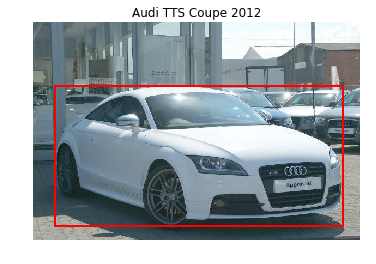

In [27]:
display_image(df_train, 0)

In [36]:
def display_range(end, start = 0):

    n = end - start
    fig, ax = plt.subplots(n, 2, figsize=(15, 5*end))

    for i in range(start, end):
        line = i - start
        
        im, title, rect = get_assets(df_train, i)
        sub = ax[line, 0]
        sub.imshow(im)
        sub.axis('off')
        sub.set_title(title)
        sub.add_patch(rect)
        
        im, title, rect = get_assets(df_test, i)
        sub = ax[line, 1]
        sub.imshow(im)
        sub.axis('off')
        sub.set_title(title)
        sub.add_patch(rect)
        
    plt.show()

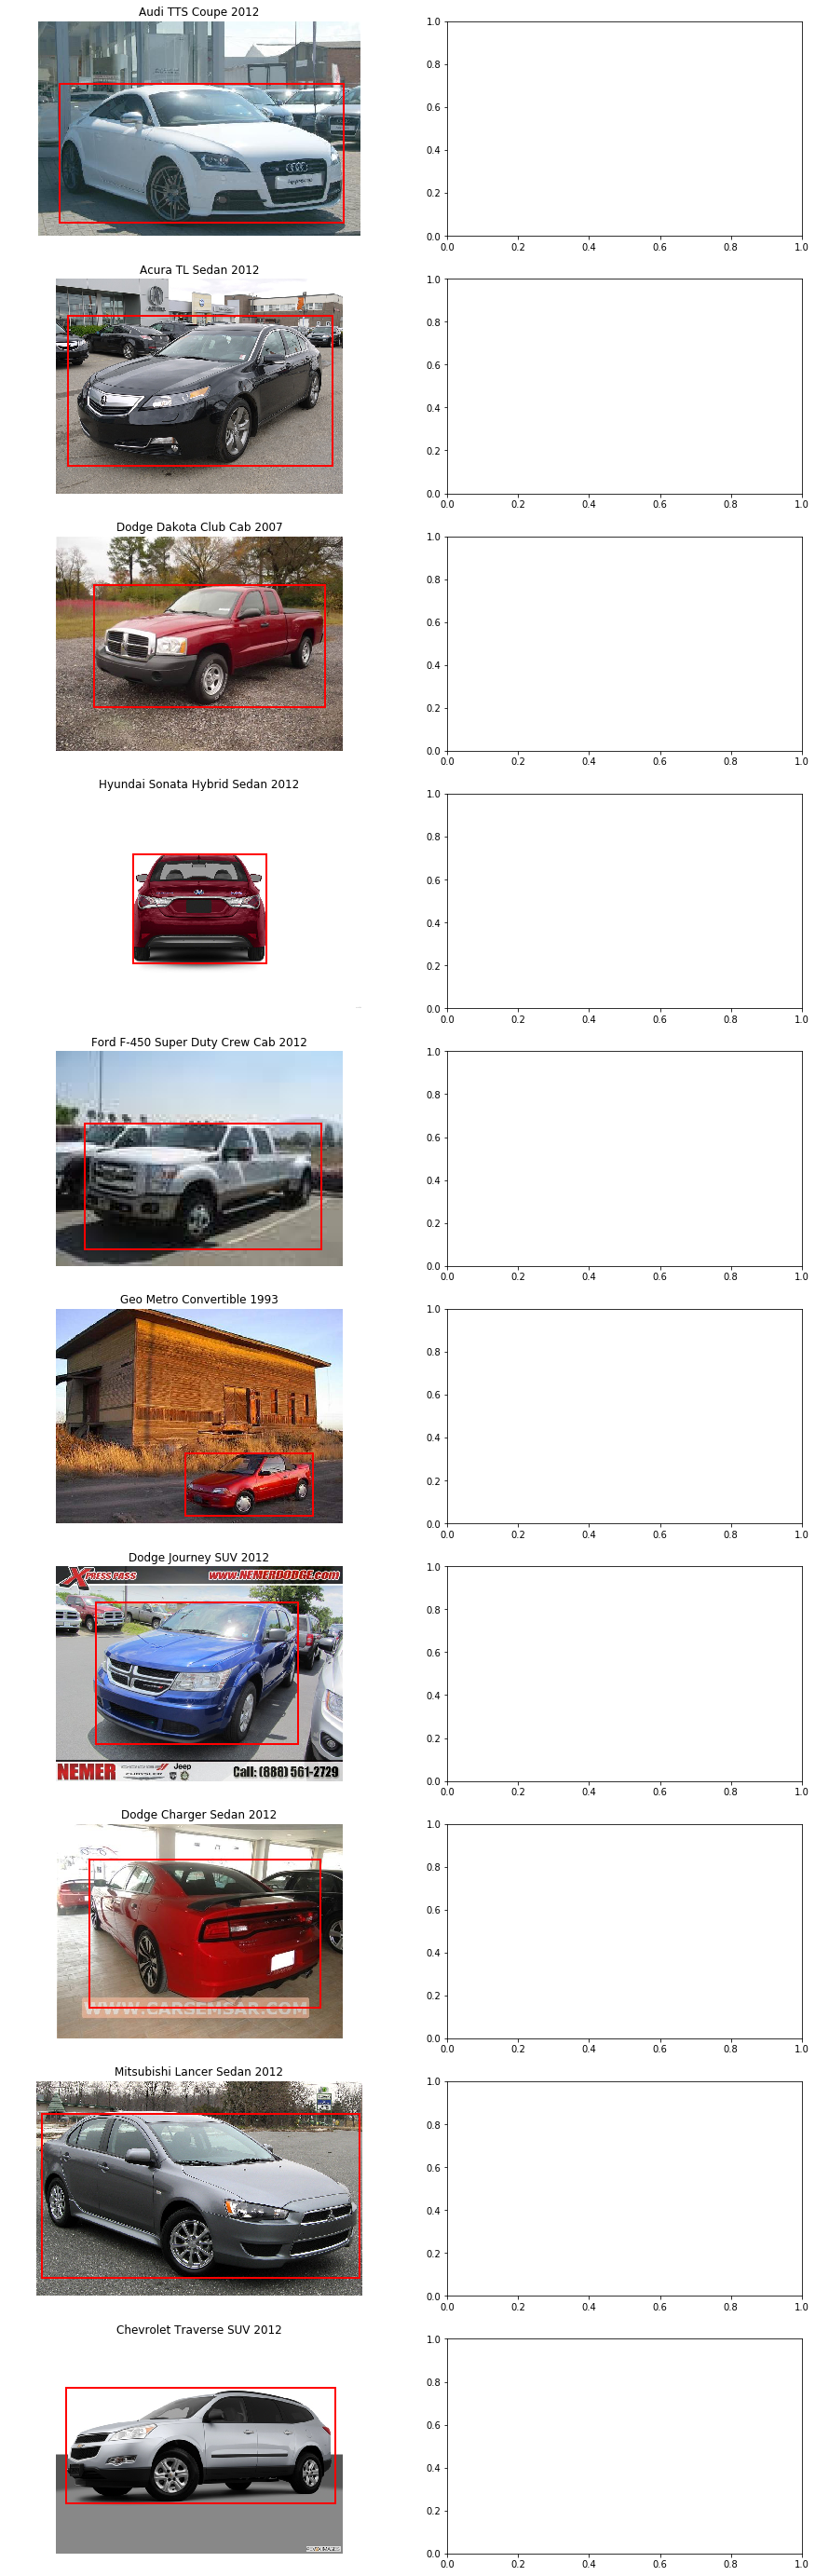

In [38]:
display_range(10)

# Class Distribution

In [31]:
freq_labels = df_train.groupby('labels').count()[['class']]
freq_labels = freq_labels.rename(columns={'class': 'count'})
freq_labels = freq_labels.sort_values(by='count', ascending=False)
freq_labels.head()

,count
labels,
GMC Savana Van 2012,68
Chrysler 300 SRT-8 2010,49
Mercedes-Benz 300-Class Convertible 1993,48
Mitsubishi Lancer Sedan 2012,48
Jaguar XK XKR 2012,47


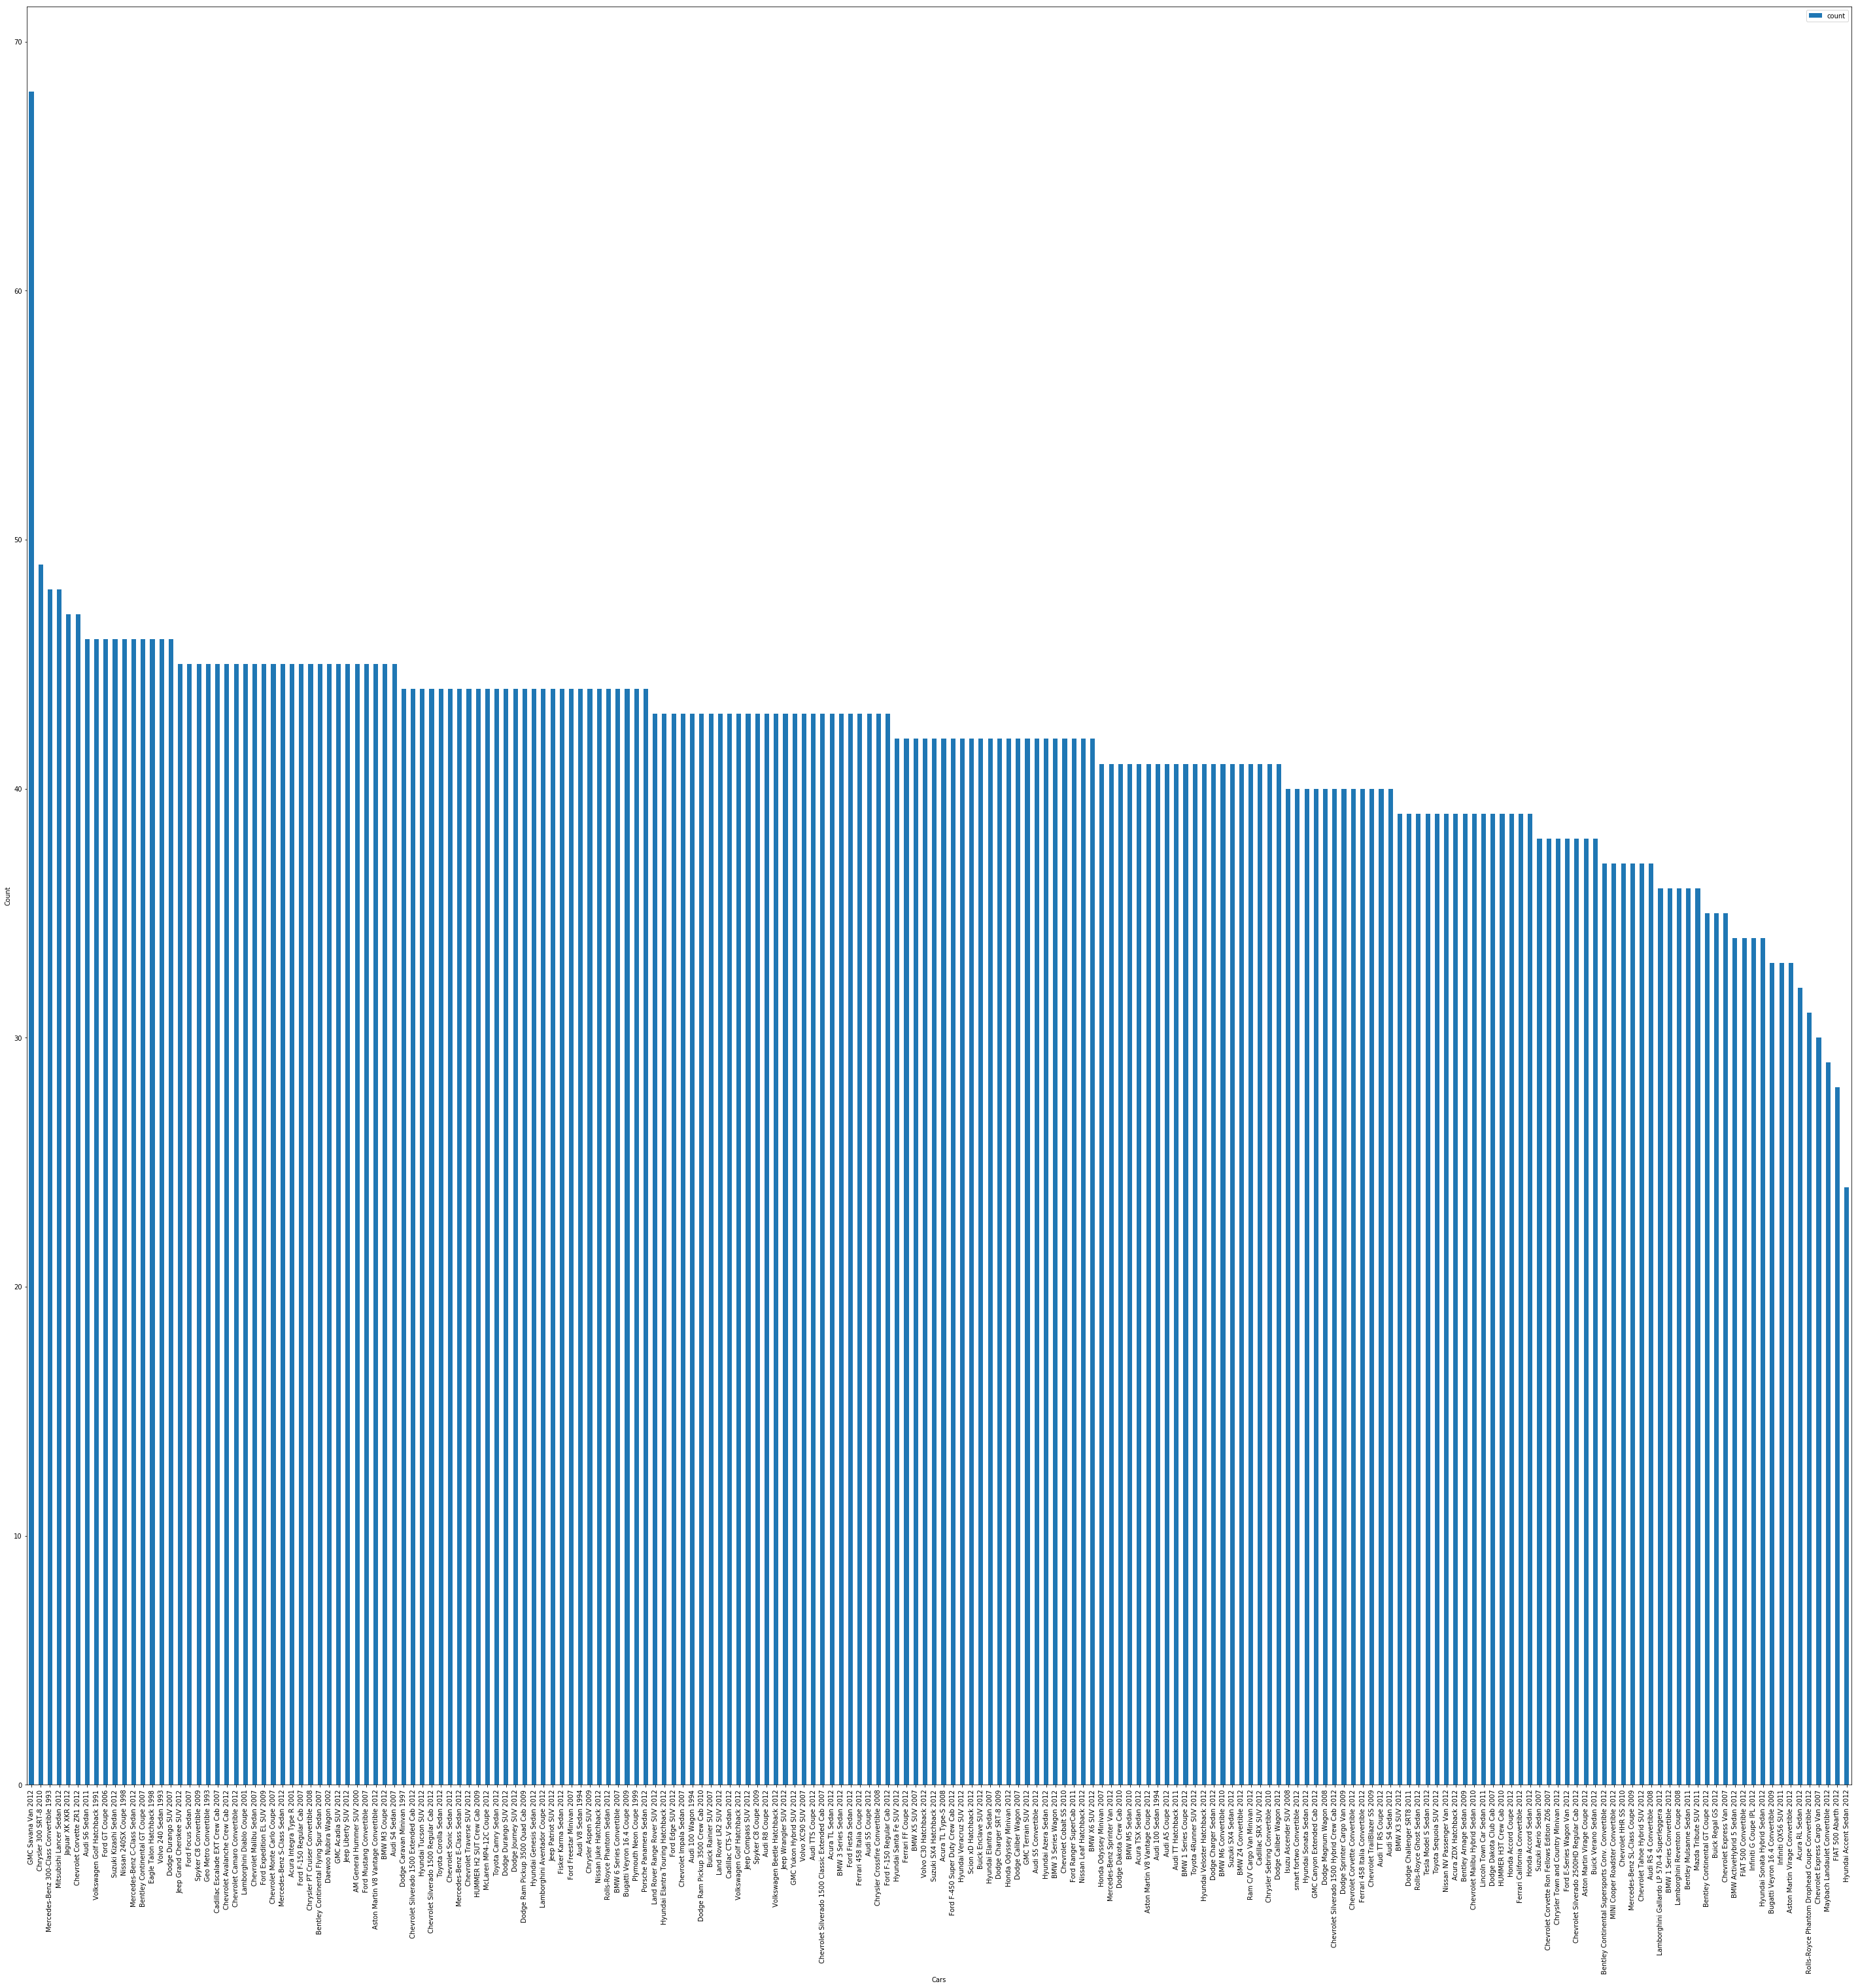

In [32]:
freq_labels.head(196).plot.bar(figsize=(50,50))
plt.xticks(rotation=90);
plt.xlabel("Cars");
plt.ylabel("Count");